In [1]:
import torch
import einops
from torch.nn import functional as F


In [2]:
names = list(open("./data/names/names.txt").read().splitlines())

In [3]:
vocab = sorted(list(set("".join(name for name in names))))
vocab = ["."] + vocab  ## "." means end of text or start of a new text"
vocab

['.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [4]:
char_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
char_to_idx

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [5]:
# I want the neural network to output the probability distribution
# of the next character given the context
# The context here is going to be 3 characters, so we have to set
# the independent variable x as 3 characters and the dependent to the next character

xs, ys = [], []
context_size = 3
for name in names[:5]:
    context = [0] * context_size
    for char in name + ".":
        idx = char_to_idx[char]
        xs.append(context)
        ys.append(idx)
        print(f'{"".join(idx_to_char[idx] for idx in context)} ---> {char}')
        context = context[1:] + [idx]
    print(name)

xs, ys = torch.tensor(xs), torch.tensor(ys)
xs.shape, ys.shape

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
emma
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
olivia
... ---> a
..a ---> v
.av ---> a
ava ---> .
ava
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
isabella
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .
sophia


(torch.Size([32, 3]), torch.Size([32]))

In [6]:
# Now we need to create an embedding matrix
# The reason behind this is that by creating a representation of the characters in a vector space,
# the model will be able to generalize for out of distribution examples
C = torch.randn((27, 2))  # 27 characters, 2 dimensions to represent them

In [66]:
C[char_to_idx["a"]], char_to_idx["a"]

(tensor([-0.5212,  0.8184]), 1)

In [7]:
# to access a specific character, we can do the following:
C[char_to_idx["a"]]

tensor([-0.5212,  0.8184])

In [8]:
# Each x in xs is exactly the indexes of the characters in the context
# We can index C with xs to get the embeddings of the characters in the context
embeds = C[xs]
embeds.shape  # (10, 3, 2) -> 10 contexts each made by 3 characters represented by 2 dimensions

torch.Size([32, 3, 2])

In [9]:
xs[3, 2] # 2nd character in the 3rd context

tensor(13)

In [10]:
# so we can index C with tensors that represent the indexes of the characters in the context
C[xs][3, 2], C[13]  

(tensor([ 0.2786, -0.3460]), tensor([ 0.2786, -0.3460]))

In [11]:
# Now we need to multiply the embeddings by the weight matrix W
# The inputs here we'll have the following shape:
# (batch_size, context_size, embedding_dim)
# So to process each context as a single vector we need to turn the 3D tensor into a 2D tensor
# By going from (batch_size, context_size, embedding_size) to (batch_size, context_size * embedding_size)
# We can do this by using a view operation
# pytorch splits the actual data from the logical representation of the tensor
embeds.view(-1, 6).shape

torch.Size([32, 6])

In [12]:
# we can also use einops rearrange to do this
einops.rearrange(embeds, 'b c d -> b (c d)').shape

torch.Size([32, 6])

In [13]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

# now we can multiply the embedded inputs by the weight matrix W
# and add the bias
h = embeds.view(-1, 6) @ W1 + b1
h.shape

torch.Size([32, 100])

In [14]:
# For better readability and generic code, we can use einops rearrange and einsum
h = einops.einsum(
    einops.rearrange(embeds, 'b c d -> b (c d)'),
    W1,
    'b d, d e -> b e'
) + b1
h.shape


torch.Size([32, 100])

In [15]:
# Following the paper, we need to apply a non-linearity to the hidden layer
# We'll use tanh
h = torch.tanh(h)
h.shape

torch.Size([32, 100])

In [16]:
# Now apply one more linear map to get the logits
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [17]:
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs.shape, probs.sum(dim=1)

(torch.Size([32, 27]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000]))

In [21]:
# Now to get the probabilities for the expected next character, we can do the following:
probs[torch.arange(probs.shape[0]), ys]

tensor([8.1804e-04, 7.8638e-11, 5.0208e-12, 1.4269e-09, 8.5621e-05, 5.9541e-01,
        1.1922e-05, 1.5546e-11, 8.5974e-08, 1.9760e-09, 2.8007e-11, 5.1757e-03,
        8.3575e-10, 1.9279e-10, 8.1383e-11, 6.9812e-07, 9.2957e-05, 2.5382e-04,
        1.0629e-07, 2.7048e-11, 2.4230e-06, 2.1069e-03, 6.8153e-06, 1.6914e-11,
        1.0247e-05, 2.2621e-03, 2.3740e-02, 6.1201e-10, 8.9535e-05, 3.3381e-10,
        1.1258e-09, 2.6412e-06])

In [22]:
# We want to maximize the likelihood of the data given the parameters
# So we'll use the average negative log likelihood
# log to avoid numerical instability
# mean to get a value with a controlled scale
# and negative to turn the maximization problem into a minimization problem, we want to minimize the loss
loss = -probs[torch.arange(probs.shape[0]), ys].log().mean()
loss

tensor(15.3216)

In summary, we have the following:

In [23]:
xs.shape, ys.shape

(torch.Size([32, 3]), torch.Size([32]))

In [24]:
generator = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6, 100), generator=generator, requires_grad=True)
b1 = torch.randn(100, generator=generator, requires_grad=True)
W2 = torch.randn((100, 27), generator=generator, requires_grad=True)
b2 = torch.randn(27, generator=generator, requires_grad=True)
params = [W1, b1, W2, b2]
sum(p.numel() for p in params)


3427

In [25]:
h1 = embeds.view(-1, 6) @ W1 + b1
logits = torch.tanh(h1) @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(probs.shape[0]), ys].log().mean()
loss

tensor(15.4018, grad_fn=<NegBackward0>)

In [26]:
# but instead of coding softmax and then calculating the loss, we can use the built-in functions
loss = F.cross_entropy(logits, ys)
loss

tensor(15.4018, grad_fn=<NllLossBackward0>)

In [27]:
for _ in range(1000):
    h1 = embeds.view(-1, 6) @ W1 + b1
    logits = torch.tanh(h1) @ W2 + b2
    loss = F.cross_entropy(logits, ys)
    loss.backward()
    for p in params:
        p.data -= p.grad * 0.1
        p.grad = None
print(loss.item())

0.2670423984527588


* We overfitted the model to the first 5 names.
* We haven't been able to decrease even more the loss because of the first context "..." that is common to all the names.
* So "..." comes before different characters in the vocabulary and the model is unable to pinpoint the next character for it
* We can inspect that by looking at the max values of the logits


In [32]:
logits.max(dim=1)

torch.return_types.max(
values=tensor([11.2809, 16.4889, 15.2956, 17.9365, 16.6901, 11.2809, 13.1831, 11.3842,
        16.7883, 17.8493, 16.6961, 21.5810, 11.2809, 12.7923, 14.5874, 15.4889,
        11.2809, 16.2893, 15.6687, 13.9393, 15.4349, 16.9288, 15.0180, 15.2797,
        15.4439, 11.2809, 14.0325, 13.7831, 16.3436, 16.7013, 19.1870, 14.4132],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

Now let's train the model for the whole dataset

In [33]:
xs, ys = [], []
context_size = 3
for name in names:
    context = [0] * context_size
    for char in name + ".":
        idx = char_to_idx[char]
        xs.append(context)
        ys.append(idx)
        context = context[1:] + [idx]

xs, ys = torch.tensor(xs), torch.tensor(ys)
xs.shape, ys.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [34]:
generator = torch.Generator().manual_seed(2147483647)
embedding = torch.randn((27, 2), requires_grad=True, generator=generator)
W1 = torch.randn((6, 100), generator=generator, requires_grad=True)
b1 = torch.randn(100, generator=generator, requires_grad=True)
W2 = torch.randn((100, 27), generator=generator, requires_grad=True)
b2 = torch.randn(27, generator=generator, requires_grad=True)
params = [embedding, W1, b1, W2, b2]
sum(p.numel() for p in params)

3481

In [36]:
# Let's decide which learning rate to use
# First let's probe the loss landscape with a small learning rate
# With 0.0001 we don't see improvements and the loss is high
# Now let's try 0.001, we see improvements but the loss is still high
# Trying with 10 we see that the loss is too high
# So a fair range would be between 0.001 and 1
exps = torch.linspace(-3, 0, 1000)
lrs = 10 ** exps

In [37]:
batch_size = 32
epochs = 1000
losses = []
for i in range(epochs):
    idxs = torch.randint(0, xs.shape[0], (batch_size,), generator=generator)
    embeds = embedding[xs[idxs]]
    h1 = torch.tanh(embeds.view(-1, 6) @ W1 + b1)
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, ys[idxs])
    
    for p in params:
        p.grad = None

    loss.backward()
    for p in params:
        p.data -= p.grad * lrs[i]
    losses.append(loss.item())
    print(loss.item())

21.805850982666016
18.852197647094727
19.07378387451172
17.046918869018555
21.199901580810547
18.2836856842041
20.470064163208008
18.923921585083008
18.289226531982422
21.261343002319336
18.16302490234375
16.44161605834961
19.99694061279297
22.460432052612305
17.33588218688965
21.703508377075195
20.23116111755371
17.7894229888916
16.10965919494629
21.12723159790039
19.27985954284668
20.105083465576172
19.305265426635742
17.05689239501953
20.99806785583496
18.714208602905273
18.35235023498535
20.251676559448242
18.216617584228516
19.176977157592773
20.99311065673828
18.235382080078125
18.48565673828125
19.0620174407959
18.293033599853516
18.267942428588867
16.379436492919922
17.963695526123047
18.183225631713867
19.327896118164062
17.14921760559082
18.8055419921875
17.2410945892334
17.924427032470703
18.858692169189453
17.633834838867188
18.503570556640625
18.91912269592285
19.876239776611328
14.435663223266602
16.176856994628906
18.730236053466797
19.120092391967773
21.029977798461914


* We can see that the sweetspot for the learning rate exponent is between -1 and -0.5
* Yielding a learning rate between 0.1 and 0.01

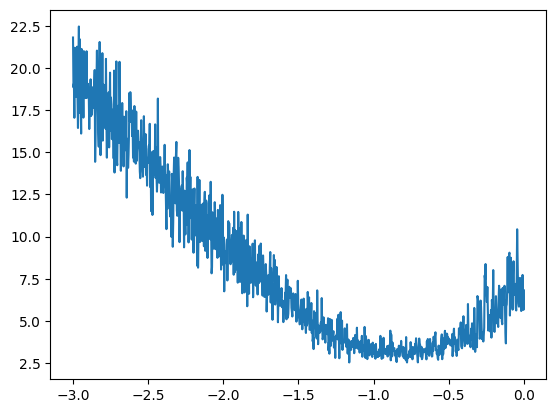

In [38]:
from matplotlib import pyplot as plt
plt.plot(exps, losses)

In [39]:
batch_size = 32
epochs = 10000
lr = 0.01
for i in range(epochs):
    idxs = torch.randint(0, xs.shape[0], (batch_size,))

    embeds = embedding[xs[idxs]]
    h1 = torch.tanh(embeds.view(-1, 6) @ W1 + b1)
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, ys[idxs])
    
    for p in params:
        p.grad = None

    loss.backward()
    for p in params:
        p.data -= p.grad * lr
print(f"final batch training loss: {loss.item()}")

embeds = embedding[xs]
h1 = torch.tanh(embeds.view(-1, 6) @ W1 + b1)
logits = h1 @ W2 + b2
loss = F.cross_entropy(logits, ys)
print(f"loss over the whole dataset: {loss.item()}")

final batch training loss: 2.7143807411193848
loss over the whole dataset: 2.5410053730010986


* The issue with out current setup is that we are using a single split to evaluate the model
* We should split the data into train, dev/validation and test sets
* Train set will be used to train the model
* Dev set will be used to tune the hyperparameters
* Test set will be used to evaluate the model
* This will allow us to understand if we are overfitting or underfitting
    * Overfitting: The model has better performance on the train set than on the dev set
    * Underfitting: The model performs very similarly on the train and dev sets
* Remember that we are using batch training, so if the batch size is too small, the gradient might be too noisy and won't allow convergence
* Also remember that larger models might require more epochs to converge
* We should also use the test set carefully to avoid overfitting for the test set


In [40]:
xs, ys = [], []
context_size = 5
for name in names:
    context = [0] * context_size
    for char in name + ".":
        idx = char_to_idx[char]
        xs.append(context)
        ys.append(idx)
        context = context[1:] + [idx]

xs, ys = torch.tensor(xs), torch.tensor(ys)
xs.shape, ys.shape

(torch.Size([228146, 5]), torch.Size([228146]))

In [41]:
train_size = int(0.8 * len(xs))
dev_size = int(0.1 * len(xs))
test_size = len(xs) - train_size - dev_size
train_size, dev_size, test_size, train_size + dev_size + test_size

(182516, 22814, 22816, 228146)

In [42]:
idxs_in_random_order = torch.randperm(len(xs))
train_idxs = idxs_in_random_order[:train_size]
dev_idxs = idxs_in_random_order[train_size:train_size + dev_size]
test_idxs = idxs_in_random_order[train_size + dev_size:]
train_idxs, dev_idxs, test_idxs
train_xs, train_ys = xs[train_idxs], ys[train_idxs]
dev_xs, dev_ys = xs[dev_idxs], ys[dev_idxs]
test_xs, test_ys = xs[test_idxs], ys[test_idxs]
train_xs.shape, train_ys.shape, dev_xs.shape, dev_ys.shape, test_xs.shape, test_ys.shape

(torch.Size([182516, 5]),
 torch.Size([182516]),
 torch.Size([22814, 5]),
 torch.Size([22814]),
 torch.Size([22816, 5]),
 torch.Size([22816]))

In [43]:
generator = torch.Generator().manual_seed(2147483647)
embedding = torch.randn((27, 10), requires_grad=True, generator=generator)
W1 = torch.randn((50, 300), generator=generator, requires_grad=True)
b1 = torch.randn(300, generator=generator, requires_grad=True)
W2 = torch.randn((300, 27), generator=generator, requires_grad=True)
b2 = torch.randn(27, generator=generator, requires_grad=True)
params = [embedding, W1, b1, W2, b2]
sum(p.numel() for p in params)

23697

In [44]:
steps = []
losses = []

In [47]:
batch_size = 64
epochs = 100000
for i in range(epochs):
    idxs = torch.randint(0, train_xs.shape[0], (batch_size,))
    embeds = embedding[train_xs[idxs]]
    h1 = torch.tanh(embeds.view(-1, 50) @ W1 + b1)
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, train_ys[idxs])
    
    for p in params:
        p.grad = None

    lr = 0.06
    loss.backward()
    for p in params:
        p.data -= p.grad * lr
    steps.append(i)
    losses.append(loss.log10().item())
print(f"batch training loss: {loss.item()}")

embeds = embedding[train_xs]
h1 = torch.tanh(embeds.view(-1, 50) @ W1 + b1)
logits = h1 @ W2 + b2
loss = F.cross_entropy(logits, train_ys)
print(f"full training set loss: {loss.item()}")

batch training loss: 2.1684672832489014
full training set loss: 2.2583673000335693


* context_size = 3
  * batch_size = 32 
    * full training set loss: 2.1507744789123535
    * dev loss: 2.1902894973754883

  * batch_size = 64 
    * full training set loss: 2.11842679977417
    * dev loss: 2.1659116744995117

* context_size = 5
  * batch_size = 32 
    * full training set loss: 2.2080495357513428
    * dev loss: 2.221489667892456

  * batch_size = 64 
    * full training set loss: 2.1547844409942627 (hidden layer size = 200)
    * dev loss: 2.177957057952881 (hidden layer size = 200)
    * full training set loss: 2.156785249710083 (hidden layer size = 300)
    * dev loss: 2.1813814640045166 (hidden layer size = 300)


In [48]:
embeds = embedding[dev_xs]
h1 = torch.tanh(embeds.view(-1, 50) @ W1 + b1)
logits = h1 @ W2 + b2
loss = F.cross_entropy(logits, dev_ys)
print(f"dev loss: {loss.item()}")

dev loss: 2.2786660194396973


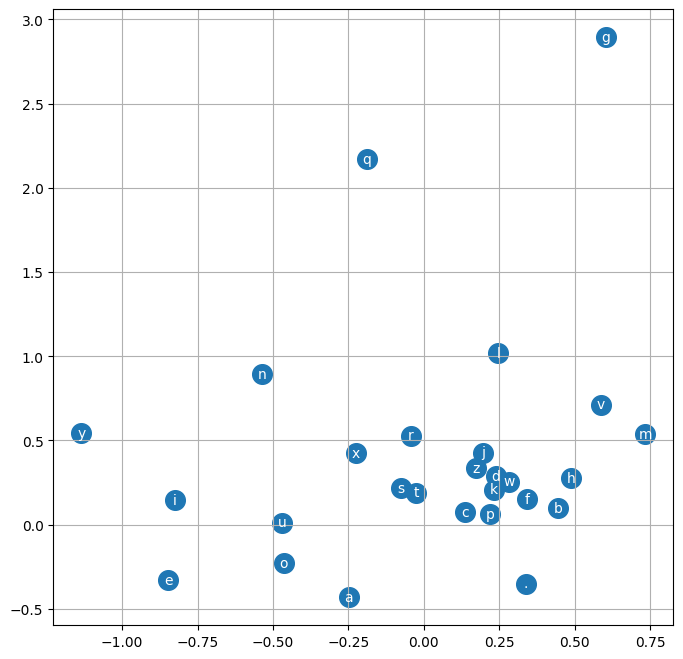

In [407]:
plt.figure(figsize=(8, 8))
plt.scatter(embedding[:, 0].data, embedding[:, 1].data, s=200)
for i in range(embedding.shape[0]):
    plt.text(
        embedding[i, 0].item(),
        embedding[i, 1].item(),
        idx_to_char[i], ha="center",
        va="center", color="white"
    )
plt.grid("minor")

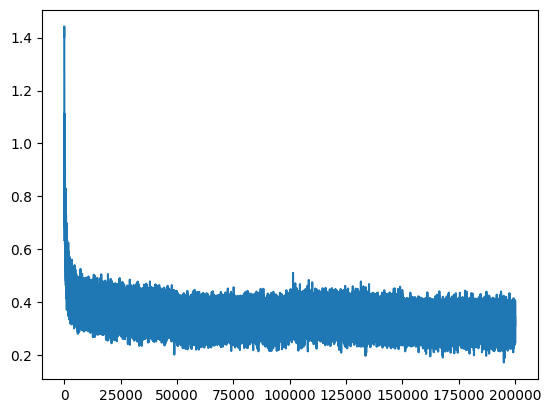

In [432]:
plt.plot(range(len(steps)), losses)

In [435]:
for i in range(10):
    init_name = ""
    context = [0, 0, 0]
    while True:
        embeds = embedding[context]
        h1 = torch.tanh(embeds.view(-1, 30) @ W1 + b1)
        logits = h1 @ W2 + b2
        next_char_idx = torch.multinomial(logits.softmax(dim=1), num_samples=1, generator=generator).item()
        context = context[1:] + [next_char_idx]
        init_name += idx_to_char[next_char_idx]
        if next_char_idx == 0:
            break
    print(init_name)

marria.
tavrajy.
jamestaly.
sumina.
docalle.
jon.
ajean.
ser.
bean.
kyrahasmiarna.


TO-DO:
* Try to play with the hyperparameters to beat a dev set loss of 2.15
    * Context size
    * Embedding size
    * Hidden size
    * Learning rate
    * Batch size
    * Epochs
* Read the paper of Bengio et al. 2003